<a href="https://colab.research.google.com/github/YaejinK/Algorithm-study/blob/master/%EC%8B%A4%EC%8A%B505_TransferLearning.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 실습05 Transfer Learning 201910938 김예진

## 1. Settings

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Colab Notebooks

/content/drive/MyDrive/Colab Notebooks


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.init as init
import torch.utils.data as data
import torchvision.datasets as dset
import torchvision.models as models
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.autograd import Variable
import time
import matplotlib.pyplot as plt
import utils

In [4]:
batch_size= 32 #64  #1
learning_rate = 0.0001
epoch = 50

n_node = 1024  # customized last layer 의 노드 수. 64, 128, 256, 512, 1024
dropratio = 0.5   # 얼마나 드랍시킬지 inverse keepratio 

imgsize = 256

## 2. Data Loader

In [5]:
#1. Training dataset
img_dir="cake/train"
train_data = dset.ImageFolder(img_dir, transforms.Compose([      
            transforms.CenterCrop(imgsize*2),    
            transforms.RandomCrop(imgsize),       
            transforms.RandomHorizontalFlip(),    
    
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
print(train_data.__len__())

train_batch = data.DataLoader(train_data, batch_size=batch_size,
                            shuffle=True, num_workers=2)

81


In [6]:
#2. Development dataset, validation dataset
img_dir="cake/val"
dev_data = dset.ImageFolder(img_dir, transforms.Compose([    
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
dev_batch = data.DataLoader(dev_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)


# 3. Test data
img_dir="cake/test"
test_data = dset.ImageFolder(img_dir, transforms.Compose([
            transforms.CenterCrop(size=imgsize),
            transforms.Resize(imgsize),
            transforms.ToTensor()
            ]))
test_batch = data.DataLoader(test_data, batch_size=batch_size,
                            shuffle=False, num_workers=2)
        
nclass = len(train_data.classes)
print("# of classes: %d" %nclass)
print(train_data.classes)
print(train_data.class_to_idx)
print(train_data.__len__())

print("Training: %d, Dev: %d, Test: %d," %(train_data.__len__(), dev_data.__len__(), test_data.__len__())),

# of classes: 3
['carrot', 'cheese', 'chocolate']
{'carrot': 0, 'cheese': 1, 'chocolate': 2}
81
Training: 81, Dev: 32, Test: 26,


(None,)

In [7]:
print(train_data.classes)
print(dev_data.classes)
print(test_data.classes)

['carrot', 'cheese', 'chocolate']
['carrot', 'cheese', 'chocolate']
['carrot', 'cheese', 'chocolate']


## 3. Model
### 1) Pretrained VGG Model

In [8]:
vgg = models.vgg19(pretrained=True)

for name,module in vgg.named_children():
    print(name)

print(list(vgg.children())[0])
print(list(vgg.children())[-1]) #fully connected layer

features
avgpool
classifier
Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(

### 2) Customized Fully Model

In [9]:
base_dim = 64
fsize = imgsize/32

class MyVGG(nn.Module):
    def __init__(self): #생성자, 구조 선언
        super(MyVGG, self).__init__()
        self.layer0 = nn.Sequential(*list(vgg.children())[0])  # [0]: features(conv), [1]: classifier(fc)
      
        self.layer1 = nn.Sequential(
            nn.Linear((int)(8*base_dim * fsize * fsize), n_node), # 주의!!!!!!
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),  # 0.3 만큼 drop 
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, n_node),
            nn.BatchNorm1d(n_node),
            nn.ReLU(),
            nn.Dropout2d(dropratio),
            
            nn.Linear(n_node, nclass), # 주의!!!!!!
        )
        # weight initialization 학습할 부분만
        for m in self.layer1.modules():
            if isinstance(m, nn.Conv2d):
                init.kaiming_normal(m.weight.data)  # REUL 일 때
                m.bias.data.fill_(0)
            if isinstance(m, nn.Linear):
                init.kaiming_normal(m.weight.data)
                m.bias.data.fill_(0)
    def forward(self, x): #model(img) = model.forward(img)
        #print(x.size())  # layer0의 사이즈를 무식하게 프린트 하여 알아낼 수 있음(batchsize, x,x,x)
        out = self.layer0(x)
        out = out.view(out.size(0), -1)
        out = self.layer1(out)
        return out

### 3) Model on GPU

In [10]:
model = MyVGG().cuda()

for params in model.layer0.parameters():
    params.required_grad = False
    
for params in model.layer1.parameters():
    params.required_grad = True
for name in model.children():
    print(name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: UserWarning: nn.init.kaiming_normal is now deprecated in favor of nn.init.kaiming_normal_.


Sequential(
  (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (1): ReLU(inplace=True)
  (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (3): ReLU(inplace=True)
  (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (6): ReLU(inplace=True)
  (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (8): ReLU(inplace=True)
  (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (11): ReLU(inplace=True)
  (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (13): ReLU(inplace=True)
  (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (15): ReLU(inplace=True)
  (16): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (17): ReLU(inplace=True)
  (18): MaxPoo

## 4. Optimizer&Loss

In [11]:
loss_func = nn.CrossEntropyLoss() #분류문제이므로
optimizer = optim.Adam(model.layer1.parameters(),lr=learning_rate)

## 5. Train

In [12]:
import utils

total_time = 0
disp_step = 10

to_train = True #스위치 역할
if (to_train==False):
    netname = 'nets/cake_vgg19_50.pkl'
    model = torch.load(netname)
else:   
    print("3 layer, n_node: %d, dropratio: %.2f" %(n_node, dropratio))
    model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
    train_corr = utils.ComputeCorr(train_batch, model)
    dev_corr = utils.ComputeCorr(dev_batch, model)
    test_corr = utils.ComputeCorr(test_batch, model)
    print("Correct of train: %.2f, dev: %.2f, test: %.2f" 
          %(train_corr, dev_corr, test_corr))
    model.train()
    
    netname = 'nets/cake_vgg19'

    # error rate graph 그리기
    x_epoch = []
    y_train_err = []
    y_dev_err = []
    y_test_err = []
    
    x_epoch.append(0)
    y_train_err.append(100.0-train_corr)
    y_dev_err.append(100.0-dev_corr)
    y_test_err.append(100.0-test_corr)
    
#     # 학습을 재시작한다면 주석 풀고 밑에 for문 주석
#     netname = '../nets/media_pre_vgg19.pkl'
#     model = torch.load(netname)
#     # 파라미터 학습 여부 결정
#     for params in model.layer0.parameters():
#         params.required_grad = False    
#     for params in model.layer1.parameters():
#         params.required_grad = True
#     for i in range(34, epoch):
    
    # 재시작하지 않는 다면
    for i in range(epoch):
        start_time = time.time()
        print("%d.." %i),
        for img,label in train_batch:
            img = Variable(img).cuda()
            label = Variable(label).cuda()

            optimizer.zero_grad()
            output = model(img)
            loss = loss_func(output,label)
            loss.backward()
            optimizer.step()

        end_time = time.time()
        duration = end_time - start_time
        total_time += duration
        if (i % disp_step == 0) or (i==epoch-1): #1.백업, 2: 학습잘되고있는지 모니터링
            torch.save(model, netname+'_%d.pkl'%i, )
            print("\n[%d/%d] loss: %.3f, " %(i, epoch, (loss.cpu()).data.numpy())),
            
            # train, dev, train accr
            model.eval()  # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
            train_corr = utils.ComputeCorr(train_batch, model)
            dev_corr = utils.ComputeCorr(dev_batch, model)
            test_corr = utils.ComputeCorr(test_batch, model)
            print("Correct of train: %.2f, dev: %.2f, test: %.2f, " 
                  %(train_corr, dev_corr, test_corr)),
            model.train()            
            print("time: %.2f sec.." %(total_time))
            
            # 에러 graph 그리기
            x_epoch.append(i+1)
            y_train_err.append(100.0-train_corr)
            y_dev_err.append(100.0-dev_corr)
            y_test_err.append(100.0-test_corr)
    print("Total time: %.2f sec" %total_time)

3 layer, n_node: 1024, dropratio: 0.50
Correct of train: 35.80, dev: 28.12, test: 34.62
0..

[0/50] loss: 1.686, 
Correct of train: 40.74, dev: 21.88, test: 38.46, 
time: 1.78 sec..
1..
2..
3..
4..
5..
6..
7..
8..
9..
10..

[10/50] loss: 0.870, 
Correct of train: 66.67, dev: 43.75, test: 61.54, 
time: 20.23 sec..
11..
12..
13..
14..
15..
16..
17..
18..
19..
20..

[20/50] loss: 0.862, 
Correct of train: 83.95, dev: 53.12, test: 61.54, 
time: 38.57 sec..
21..
22..
23..
24..
25..
26..
27..
28..
29..
30..

[30/50] loss: 1.290, 
Correct of train: 83.95, dev: 56.25, test: 57.69, 
time: 56.59 sec..
31..
32..
33..
34..
35..
36..
37..
38..
39..
40..

[40/50] loss: 0.557, 
Correct of train: 82.72, dev: 56.25, test: 53.85, 
time: 74.57 sec..
41..
42..
43..
44..
45..
46..
47..
48..
49..

[49/50] loss: 0.722, 
Correct of train: 90.12, dev: 56.25, test: 61.54, 
time: 90.99 sec..
Total time: 90.99 sec


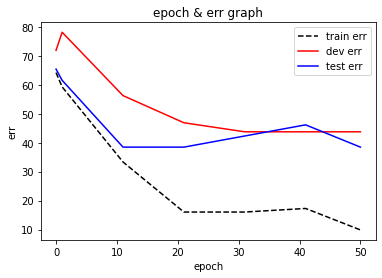

In [13]:
# epoch-err curve 
if (to_train):
    plt.plot(x_epoch, y_train_err, color='black', label='train err', linestyle='--')
    plt.plot(x_epoch, y_dev_err, color='red', label='dev err')
    plt.plot(x_epoch, y_test_err, color='blue', label='test err')
    
    plt.xlabel('epoch')
    plt.ylabel('err')
    plt.title('epoch & err graph')
    plt.legend(loc="upper right")
    plt.show()

## 6. Evaluation for dev & test data

Normalized confusion matrix


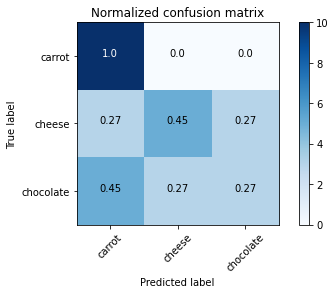

Confusion matrix, without normalization


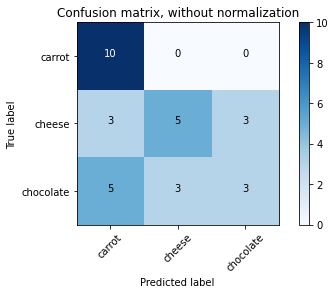

	 acc  |	 pre  |	 rec  |	 f1
 carrot: 0.75 |	 0.56 |	 1.00 |	 0.71
 cheese: 0.56 |	 0.62 |	 0.45 |	 0.53
 chocolate: 0.66 |	 0.50 |	 0.27 |	 0.35
*accuracy: 0.66, precision: 0.56, recall: 0.58, *f1 score: 0.53
[AP]
carrot: 0.77
cheese: 0.62
chocolate: 0.51

[mAP] 0.631
[miAP] 0.812


(array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 2, 1, 1, 1, 1, 0, 2, 0, 1, 2, 0, 1,
        2, 0, 2, 1, 0, 1, 0, 0, 2, 0]),
 array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 2,
        2, 2, 2, 2, 2, 2, 2, 2, 2, 2]),
 array([0.43295097, 0.58428711, 0.9531759 , 0.81589532, 0.80711997,
        0.94439012, 0.9665882 , 0.64864653, 0.92788839, 0.62267429,
        0.44043604, 0.58513814, 0.46210167, 0.50218272, 0.74631143,
        0.71591938, 0.58911854, 0.89089954, 0.51173723, 0.65852839,
        0.59410006, 0.56632125, 0.49418727, 0.67445666, 0.62500757,
        0.6171276 , 0.44012234, 0.53379744, 0.63110876, 0.84726971,
        0.45721367, 0.80944723]))

In [14]:
model.eval()   # evaluation(test) mode 로 바꾸기 -> dropout, batch normalization 에 영향을 줌.
utils.EvaluateClassifier(dev_batch, model, dev_data.classes, batch_size)

Normalized confusion matrix


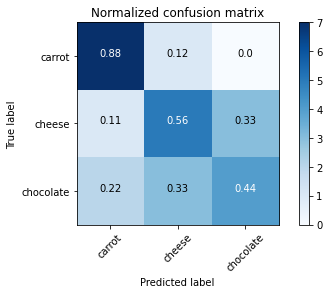

Confusion matrix, without normalization


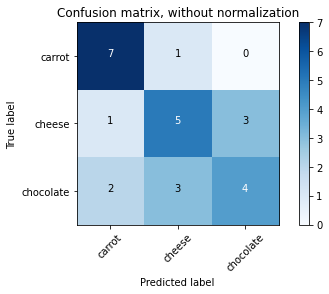

	 acc  |	 pre  |	 rec  |	 f1
 carrot: 0.85 |	 0.70 |	 0.88 |	 0.78
 cheese: 0.62 |	 0.56 |	 0.56 |	 0.56
 chocolate: 0.69 |	 0.57 |	 0.44 |	 0.50
*accuracy: 0.72, precision: 0.61, recall: 0.62, *f1 score: 0.61
[AP]
carrot: 0.84
cheese: 0.57
chocolate: 0.68

[mAP] 0.694
[miAP] 0.821


In [15]:
model.eval()
_, _,_ = utils.EvaluateClassifier(test_batch, model, test_data.classes, batch_size)

Category: carrot
 True predicted images/total carrot category: 7 / 8
Predicted probability:
[0.5586546  0.17707942 0.26426598]


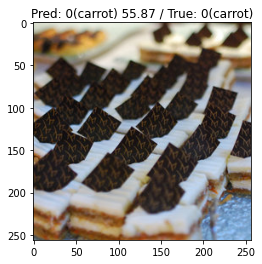

 False predicted images/total carrot category: 1 / 8
Predicted probability:
[0.4338483  0.45672062 0.1094311 ]


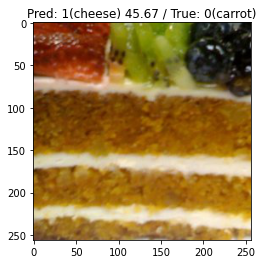

Category: cheese
 True predicted images/total cheese category: 5 / 9
Predicted probability:
[0.08391774 0.4616408  0.45444146]


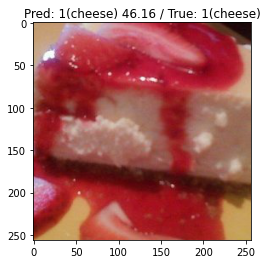

 False predicted images/total cheese category: 4 / 9
Predicted probability:
[0.13647625 0.34283432 0.5206894 ]


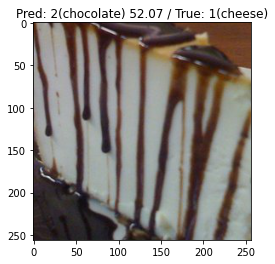

Category: chocolate
 True predicted images/total chocolate category: 4 / 9
Predicted probability:
[0.12969026 0.2935677  0.57674205]


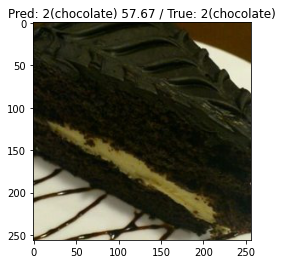

 False predicted images/total chocolate category: 5 / 9
Predicted probability:
[0.08569422 0.46147346 0.4528323 ]


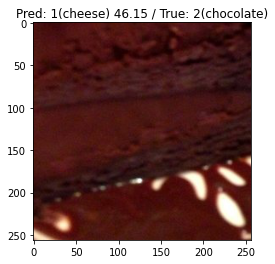

In [16]:
utils.VisTFPred(test_batch, model, test_data.classes, batch_size, i_n=1)